### **Project Overview:**

*This project originated from the need to manipulate and analyze data. Opting to steer clear of commonplace, pre-existing datasets, I chose to construct my dataset using a Python program and the Requests library. The data was sourced from Kinopoisk, and subsequent to retrieval, it was organized into five distinct tables. Each table encapsulates specific information about a film, facilitating convenient data management with each table responsible for its designated parameters.*

### **Project Objective:**

*The overarching aim of this project is to discern relationships and correlations among the various parameters associated with each film. By conducting a thorough analysis, the project seeks to identify potential areas of growth and uncover insights that can contribute to a more comprehensive understanding of the dataset.*

*Importing necessary libraries.*

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
plt.style.use('dark_background')

*Connecting dataframes from our excel spreadsheets.*


In [66]:
df1 = pd.read_excel('dates_table.xlsx')
df2 = pd.read_excel('genres_table.xlsx')
df3 = pd.read_excel('premiers_table.xlsx')
df4 = pd.read_excel('ratings_table.xlsx')
df5 = pd.read_excel('team_table.xlsx')

*Preprocessing of data in dataframes.*


In [67]:
# Delete 'Main Character' column and duplicates of producer

df5 = df5.drop(columns='Main Character').drop_duplicates(subset='Producer')

# Delete Age column, b/c there is an error on the Kinopoisk. All ages are +18

df3 = df3.drop(columns='Age')

*Joining df's by a common key.*

In [68]:
df = df1.merge(df2, on = 'Id')
df = df.merge(df3, on = 'Id')
df = df.merge(df4, on = 'Id')
df = df.merge(df5, on = 'Id')


### **Editing common DataFrame.**


*Converting duration from hours to minutes.*

In [69]:
def into_minutes(x):
    if isinstance(x, str):
        x = x.strip('минутыа')
        if 'а' in x:
            if x[5]=='а': #2 часА
                x = list(map(int,x.split(' часа ')))
            else: # 1 час
                x = list(map(int,x.split(' час ')))
            return x[0]*60+x[1]  
        return int(x)
    return x

df['Duration'] = df['Duration'].apply(into_minutes)

*Converting date to format yyyy-mm-dd.*

In [70]:
month = {'января':'1',
         'февраля':'2',
         'марта':'3',
         'апреля':'4',
         'мая':'5',
         'июня':'6',
         'июля':'7',
         'августа':'8',
         'сентября':'9',
         'октября':'10',
         'ноября':'11',
         'декабря':'12'}

def into_date(x):
    if isinstance(x, str):
        date = x.split()
        date = date[0]+' '+month[date[1]]+' '+date[2]
        return pd.to_datetime(date, format='%d %m %Y')
    return x

df['Premiere in Russia'] =df['Premiere in Russia'].apply(into_date)
df['World premiere'] =df['World premiere'].apply(into_date)
df['Online premiere'] = df['Online premiere'].apply(into_date)

*Converting budget to RUR.*

In [71]:
# Let's see what currencies we have
currency_list = [(''.join(list(currency for currency in film_budget if not currency.isdigit())).strip() 
                  if isinstance(film_budget, str) else ' ') for film_budget in df['Budget'].unique()]
currency_list.remove(' ')
currency_list = set(currency_list)

# {'$', 'CAD', 'CHF', 'CNY', 'INR', 'KRW', 'NOK', 'PKR', 'RUR', '€'}

# Let's make a dictionaty based on them
currency_into_rur = {
    'RUR': 1,
    '$' : 90,
    '€' : 100,
    'CAD' : 65,
    'CHF' : 100,
    'CNY' : 12,
    'INR' : 1.1,
    'KRW' : 0.066,
    'NOK' : 8.4,
    'PKR' : 0.3
}

# Function for converting to RUR

def to_rur(x):
    if isinstance(x, str):
        budget = int(''.join([i for i in x if i.isdigit()]))
        currency = ''.join([i for i in x if not i.isdigit()]).strip()
        return budget*currency_into_rur[currency]
    return x

# Converting our Budget column

df['Budget'] = df['Budget'].apply(to_rur)


### **Correlations.**

*Relationships between different values. This analysis can provide insights into how certain factors may influence or be related to each other, contributing to a better understanding of underlying trends or dependencies in the data.*

#### **Common correlation.**

*Let's look at the general correlation between the values.*

<Axes: >

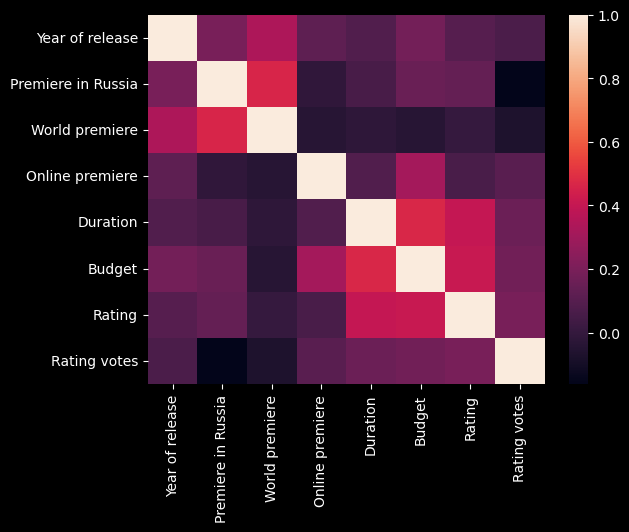

In [72]:
df_test = df[['Year of release', 'Premiere in Russia', 'World premiere','Online premiere','Duration','Budget','Rating','Rating votes']].corr()
sns.heatmap(df_test)

*Unfortunately , there is no obvious correlation between certain values. There is a slight correlation between Duration and Budget, we will check it later.*

### **Duration.**

#### **Duration Distribution.**


*I created this graph to observe the distribution and determine the most frequent duration.*

(array([  4.,   2.,   4.,   2.,  13.,  28.,  44.,  87., 198., 158., 136.,
         76.,  60.,  58.,  41.,  41.,  14.,  10.,   7.,   3.,   9.,   5.,
          1.,  13.,   7.]),
 array([ 46.  ,  51.32,  56.64,  61.96,  67.28,  72.6 ,  77.92,  83.24,
         88.56,  93.88,  99.2 , 104.52, 109.84, 115.16, 120.48, 125.8 ,
        131.12, 136.44, 141.76, 147.08, 152.4 , 157.72, 163.04, 168.36,
        173.68, 179.  ]),
 <BarContainer object of 25 artists>)

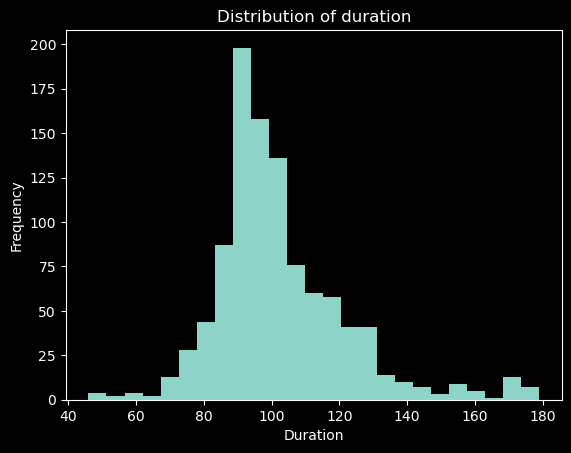

In [73]:
plt.title('Distribution of duration')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.hist(df['Duration'], bins = 25)

*We can observe that the typical duration falls within the range of approximately 90 to 110 minutes. A normal distribution can be useful for identifying errors in data, for example, and estimating the average duration of a movie.*

#### **Duration & Mpaa.**

*Here we look at the relationship between Duration and Mpaa.*

**Hypothesis**

The higher the age group, the higher the mean duration

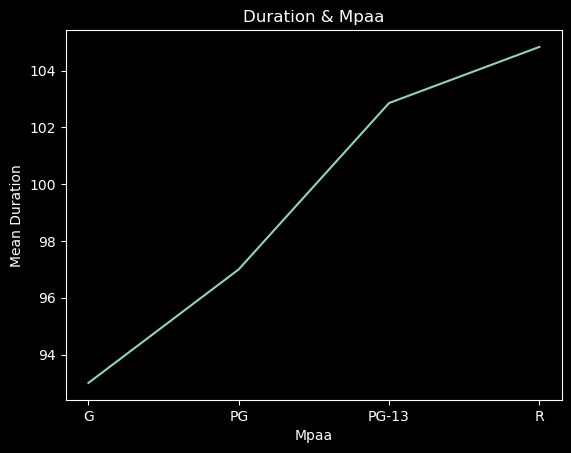

In [74]:
df_test_1 = df[~df['Mpaa'].isna()].drop_duplicates(subset = 'Title')
DURATION_MPAA = df_test_1.groupby(df_test_1['Mpaa'])['Duration'].agg(['min','max','mean','count']).reset_index()

plt.title('Duration & Mpaa')
plt.xlabel('Mpaa')
plt.ylabel('Mean Duration')
plt.plot(DURATION_MPAA['Mpaa'],DURATION_MPAA['mean'])
plt.show()      

*Our hypothesis has been confirmed; from the graph, we observe a clear correlation between the duration of the film and the Mpaa. I think it is because films with a higher Mpaa are more intense. They can depict more information, actions, moments, etc.*

#### **Duration & Budget.**

*Now I want to see the duration of the film and its budget.*

**Hypothesis:**

*The longer the duration, the higher the budget, because with a higher budget, we can depict more information for audience.*

C:\Users\My End_1ess C\AppData\Local\Temp\ipykernel_2196\627217675.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  DURATION_BUDGET = DURATION_BUDGET.groupby(['Duration'])['Budget'].mean().reset_index()


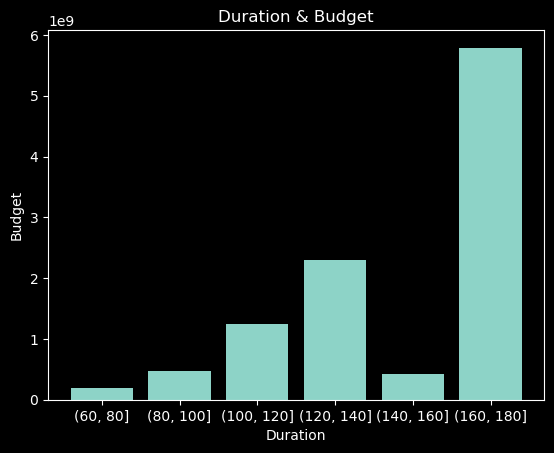

In [75]:
# mean budget in duration intervals
df_test = df[(df['Budget'].notna()) & (df['Duration'].notna()) & (df['Budget']!=0)]
DURATION_BUDGET = df_test.drop_duplicates(subset = 'Title')[['Budget','Duration']]
DURATION_BUDGET['Duration'] = pd.cut(DURATION_BUDGET['Duration'], bins = [60,80,100,120,140,160,180])
DURATION_BUDGET = DURATION_BUDGET.groupby(['Duration'])['Budget'].mean().reset_index()

#interval to string
DURATION_BUDGET['Duration'] = DURATION_BUDGET['Duration'].astype(str)

plt.title('Duration & Budget')
plt.xlabel('Duration')
plt.ylabel('Budget')
plt.bar(DURATION_BUDGET['Duration'], DURATION_BUDGET['Budget'])
plt.show()

*Our hypothesis is confirmed, but there is an interesting result because films with a duration of 140-160 minutes have a low budget. This is because we have a small number of these films:*

In [76]:
df_test = df[(df['Duration']>140) & (df['Duration']<160) & (df['Budget'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')
df_test

,Id,Year of release,Premiere in Russia,World premiere,Online premiere,Genre,Title,Duration,Mpaa,Budget,Movie distributor,Rating,Rating votes,Rating IMDB,Producer
684,395,2022,2023-09-28,2023-09-28,NaT,боевик,Легенда о Мауле,153.0,NaN,210000000.0,Indian Films,8.8,10,8.7,Билал Лашари
774,442,2023,2023-10-19,2023-10-19,2023-12-23,криминал,Анатомия падения,151.0,NaN,620000000.0,ПРОвзгляд,7.8,25,7.8,Жюстин Трие


*Only two films have this duration and budget. That's why the data within this range appears weak.*

#### **Duration & Movie Distributor.**

*I wanted to see which distributors prefer a certain duration and examine the top 10 distributors with the longest average duration.*

In [78]:
df_test = df[(df['Movie distributor'].notna()) & (df['Duration'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')
DURATION_MOVIE_DISTRIBUTOR = df_test.groupby(['Movie distributor'])['Duration'].mean().reset_index().sort_values(by = 'Duration', ascending=False)
DURATION_MOVIE_DISTRIBUTOR.head(5)


,Movie distributor,Duration
8,Indian Films,145.923077
4,BASE Development,123.250000
9,KION,115.000000
36,Русский репортаж,109.600000
25,Кино.Арт.Про,109.500000


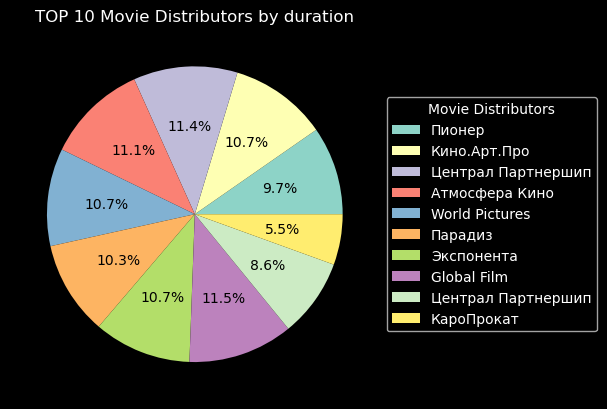

In [79]:
data = df_test['Duration'][:10]
distributors = df_test['Movie distributor'][:10]

plt.pie(data, autopct=lambda pct: f"{pct:.1f}%", textprops=dict(color="k"))

plt.legend(distributors,
          title="Movie Distributors",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("TOP 10 Movie Distributors by duration")

plt.show()

*On this graph we can observe the distribution of distributors. It can be helpful for us to determine if there is a connection between the average duration and the success of distributors.*

#### **Duration & Rating.**

*It's interesting to see the correlation between duration and rating.*

**Hypothesis:**

*The longer duration, the higher rating.*

C:\Users\My End_1ess C\AppData\Local\Temp\ipykernel_2196\4015235019.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  DURATION_RATING = DURATION_RATING.groupby(['Rating'])['Duration'].mean().reset_index()


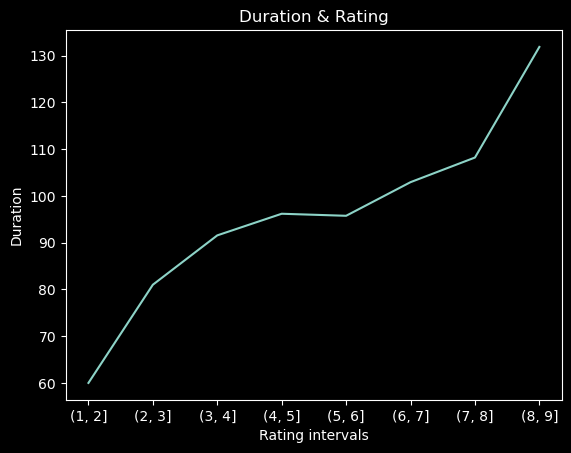

In [117]:
df_test = df[(df['Rating'].notna()) & (df['Duration'].notna())]
DURATION_RATING = df_test.drop_duplicates(subset = 'Title')[['Rating','Duration']]
DURATION_RATING['Rating'] = pd.cut(DURATION_RATING['Rating'], bins = [1,2,3,4,5,6,7,8,9])
DURATION_RATING = DURATION_RATING.groupby(['Rating'])['Duration'].mean().reset_index()
DURATION_RATING['Rating'] = DURATION_RATING['Rating'].astype(str)


plt.title('Duration & Rating')
plt.xlabel('Rating intervals')
plt.ylabel('Duration')
plt.plot(DURATION_RATING['Rating'], DURATION_RATING['Duration'])

*We see that the higher the rating, the longer the duration, perhaps because with a longer duration, the audience can immerse themselves in the film, and the film can depict more captivating moments.*

#### **Duration & Genre.**

*Also We can also examine the relationship between duration and genre.*

**Hypothesis:**

*The horror genre has one of the shortest durations among other genres.*

In [81]:
df_test = df[(df['Genre'].notna()) & (df['Duration'].notna())]
DURATION_GENRE = df_test[['Genre','Duration']]
DURATION_GENRE = DURATION_GENRE.groupby(['Genre'])['Duration'].mean().reset_index().sort_values(by = 'Duration')

DURATION_GENRE.head(5)


,Genre,Duration
8,детский,72.333333
2,балет,80.000000
0,анимация,83.693878
9,документальный,88.944444
23,ужасы,96.000000


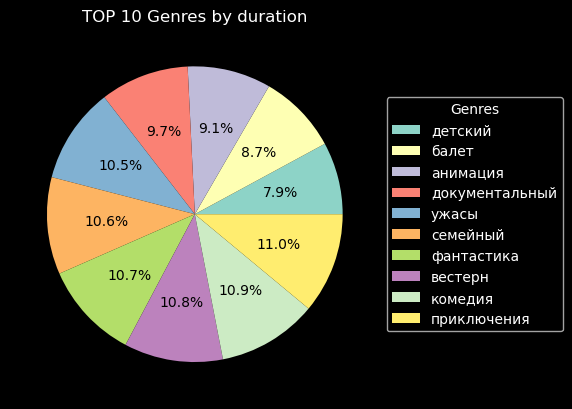

In [82]:
data = DURATION_GENRE['Duration'][:10]
distributors = DURATION_GENRE['Genre'][:10]

plt.pie(data, autopct=lambda pct: f"{pct:.1f}%", textprops=dict(color="k"))

plt.legend(distributors,
          title="Genres",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("TOP 10 Genres by duration")

plt.show()

*From the graph, we can see that films have the shortest duration in genres like children's, ballet, animation, and documentary. The horror genre is only in the fifth place.*

### **Mpaa.**

#### **Mpaa distribution.**

*Let's look at the age distribution. It's interesting to see which age group is the most significant.*

(array([13.,  0.,  0., 48.,  0.,  0.,  7.,  0.,  0.,  1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

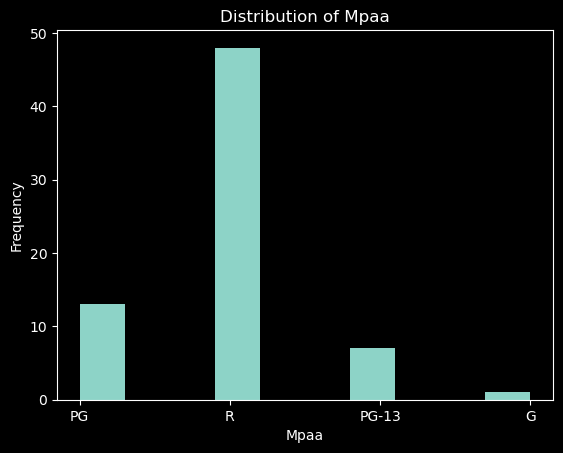

In [83]:
df_test = df[~df['Mpaa'].isna()].drop_duplicates(subset = 'Title')
plt.title('Distribution of Mpaa')
plt.xlabel('Mpaa')
plt.ylabel('Frequency')
plt.hist(df_test['Mpaa'])

*As we can see, the R group has the highest frequency. It can tell us that distributors prefer the R group.*

#### **Mpaa & Budget.**	


Also, it would be beneficial to examine the budget and mpaa as well.

**Hypothesis:**

The higher the MPAA group, the higher the budget.

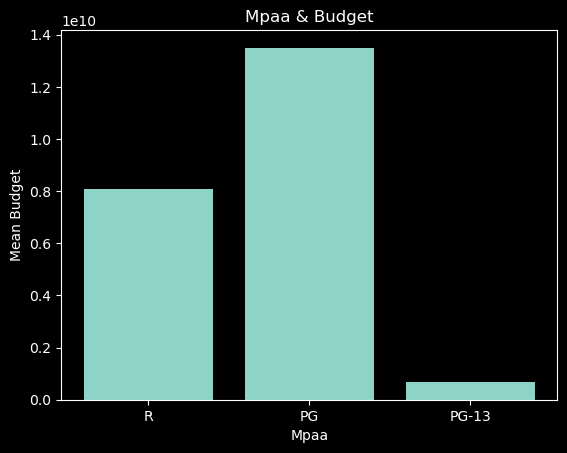

In [84]:
df_test = df[(df['Mpaa'].notna()) & (df['Budget'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')
MPAA_BUDGET = df_test[['Mpaa','Budget']]
MPAA_BUDGET.groupby('Mpaa')['Budget'].mean().reset_index()

plt.title('Mpaa & Budget')
plt.ylabel('Mean Budget')
plt.xlabel('Mpaa')
plt.bar(MPAA_BUDGET['Mpaa'], MPAA_BUDGET['Budget'])
plt.show()

*Despite the fact that there are many R group films, the PG group has the highest budget. It tells us that it is the most sponsored. Our hypothesis is not confirmed.*

#### **Mpaa & Movie Distributor.**	

*Now, let's take a look at the MPAA and movie distributor.*

**Hypothesis:**

*Movie Distributors prefer group with higher age group.*

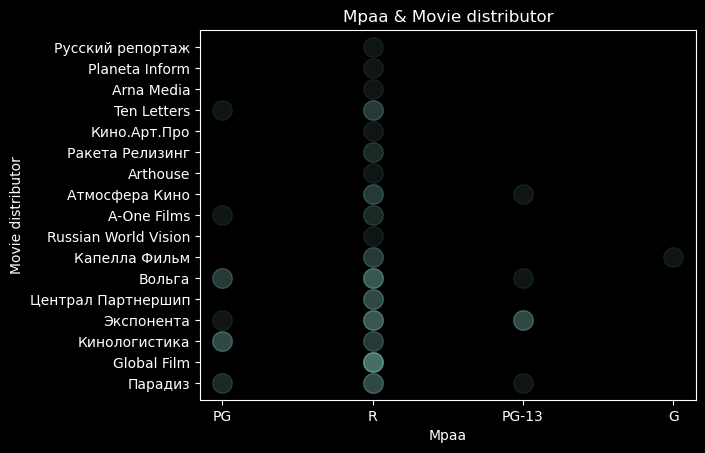

In [85]:
df_test = df[(df['Mpaa'].notna()) & (df['Movie distributor'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')
MPAA_BUDGET = df_test[['Mpaa','Movie distributor']]

# plt.title('Mpaa & Movie distributor')
# plt.xlabel('Mpaa')
# plt.ylabel('Movie distributor')
# plt.bar(MPAA_BUDGET['Mpaa'], MPAA_BUDGET['Movie distributor'])
# plt.show()

colors = np.random.rand(len(df_test['Mpaa']))
plt.title('Mpaa & Movie distributor')
plt.xlabel('Mpaa')
plt.ylabel('Movie distributor')
plt.scatter(df_test['Mpaa'],df_test['Movie distributor'], s = 200, alpha=0.1)
plt.show()

*Yes, our hypothesis is confirmed. On this graph, we can observe the density of points for the R group.*

*Let's create another graph to better visualize the correlation:*

C:\Users\My End_1ess C\AppData\Local\Temp\ipykernel_2196\1842392004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MPAA_BUDGET['num'] = 1
C:\Users\My End_1ess C\AppData\Local\Temp\ipykernel_2196\1842392004.py:2: FutureWarning: The provided callable <function sum at 0x000002004B0CA3E0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  MPAA_BUDGET = pd.pivot_table(MPAA_BUDGET, index = 'Movie distributor', columns = 'Mpaa', values = 'num', aggfunc=np.sum)


<Axes: xlabel='Mpaa', ylabel='Movie distributor'>

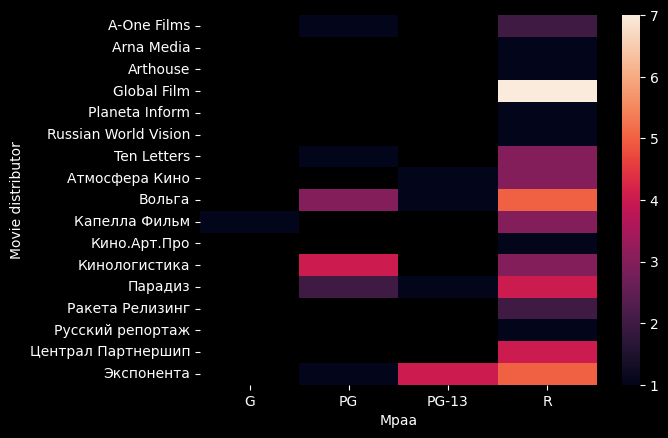

In [86]:
MPAA_BUDGET['num'] = 1
MPAA_BUDGET = pd.pivot_table(MPAA_BUDGET, index = 'Movie distributor', columns = 'Mpaa', values = 'num', aggfunc=np.sum)
sns.heatmap(MPAA_BUDGET)

*This graph further reinforces that we were correct, and distributors prefer higher age group.*

#### **Mpaa & Rating.**	

*Let's examine the correlation between age and rating.*

**Hypothesis:**

*The group with the lowest age has the highest average rating.*

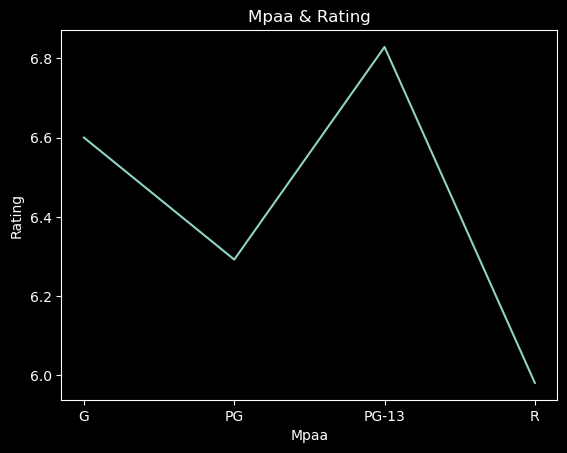

In [87]:
df_test = df[(df['Mpaa'].notna()) & (df['Rating'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')[['Mpaa','Rating']]
MPAA_RATING = df_test.groupby(['Mpaa'])['Rating'].mean().reset_index()

plt.title('Mpaa & Rating')
plt.xlabel('Mpaa')
plt.ylabel('Rating')
plt.plot(MPAA_RATING['Mpaa'], MPAA_RATING['Rating'])
plt.show()

*We were right because, in my opinion, animated films cannot have the lowest rating. They are meant for kids. Children are more forgiving than adults.*

#### **Mpaa & Genre.**	

*For these values, I decided to create a pivot table for better visualization.*

**Hypothesis:**

*The criminal genre is in one of the leading positions within the R group.*

C:\Users\My End_1ess C\AppData\Local\Temp\ipykernel_2196\2698810912.py:4: FutureWarning: The provided callable <function sum at 0x000002004B0CA3E0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  MPAA_GENRE = pd.pivot_table(df_test, index = 'Genre', columns = 'Mpaa', values='nums',aggfunc=np.sum)


<Axes: xlabel='Mpaa', ylabel='Genre'>

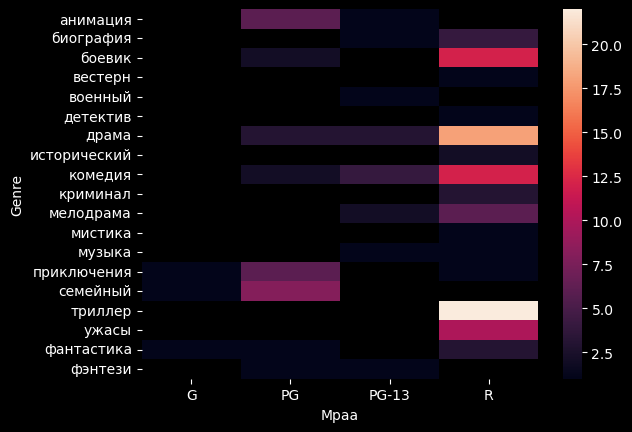

In [88]:
df_test = df[(df['Mpaa'].notna()) & (df['Genre'].notna())]
df_test = df_test[['Mpaa','Genre']]
df_test['nums'] = 1
MPAA_GENRE = pd.pivot_table(df_test, index = 'Genre', columns = 'Mpaa', values='nums',aggfunc=np.sum)
sns.heatmap(MPAA_GENRE)

*Our assumption was incorrect; in the R group, the criminal genre is almost at the bottom. At the top are genres such as horror, thriller, and drama.*

### **Budget.**

*It could be very interesting to look at the budget distribution.*

#### **Budget distribution.**

(array([113.,  39.,   9.,  10.,  15.,   6.,   6.,   0.,   3.,   1.,   0.,
          1.,   3.,   0.,   0.,   0.,   1.,   3.,   0.,   1.,   0.,   2.,
          3.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   3.,   0.,   3.]),
 array([0.0000000e+00, 3.6481500e+08, 7.2963000e+08, 1.0944450e+09,
        1.4592600e+09, 1.8240750e+09, 2.1888900e+09, 2.5537050e+09,
        2.9185200e+09, 3.2833350e+09, 3.6481500e+09, 4.0129650e+09,
        4.3777800e+09, 4.7425950e+09, 5.1074100e+09, 5.4722250e+09,
        5.8370400e+09, 6.2018550e+09, 6.5666700e+09, 6.9314850e+09,
        7.2963000e+09, 7.6611150e+09, 8.0259300e+09, 8.3907450e+09,
        8.7555600e+09, 9.1203750e+09, 9.4851900e+09, 9.8500050e+09,
        1.0214820e+10, 1.0579635e+10, 1.0944450e+10, 1.1309265e+10,
        1.1674080e+10, 1.2038895e+10, 1.2403710e+10, 1.2768525e+10,
        1.3133340e+10, 1.3498155e+10, 1.3862970e+10, 1.4227785e+10,
        1.4592600e+10]),
 <BarContainer object

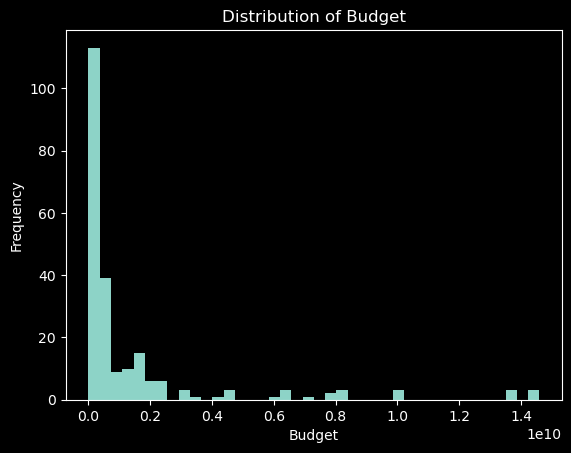

In [89]:
df_test = df_test = df[(df['Budget'].notna())]
plt.title('Distribution of Budget')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.hist(df_test['Budget'], bins = 40)

*We can see that a significant portion of all budgets falls between 0.0 and 0.2e+10 on this plot. Films are most frequently made with a small budget.*

#### **Budget & Movie Distributor.**

*The correlation between budget and movie distributor can show us the most interested and successful distributors.*

In [90]:
df_test = df[(df['Budget'].notna()) & (df['Movie distributor'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')[['Budget','Movie distributor']]
df_test = df_test.groupby(['Movie distributor'])['Budget'].mean().reset_index().sort_values(by = 'Budget', ascending=False)

df_test.head(5)

,Movie distributor,Budget
12,Вольга,2.424960e+09
15,КароПрокат,2.300918e+09
23,Парадиз,1.804000e+09
30,Экспонента,1.654111e+09
4,Global Film,1.607430e+09


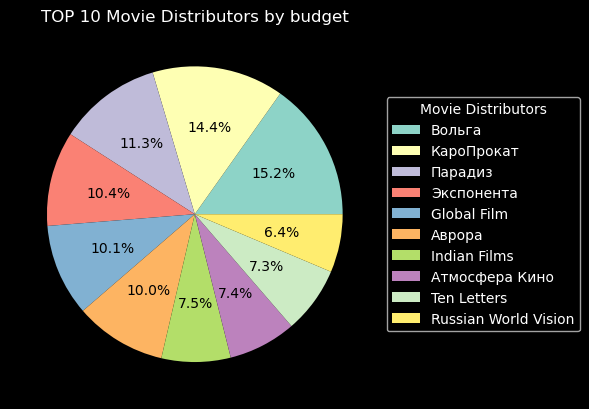

In [91]:
data = df_test['Budget'][:10]
genres = df_test['Movie distributor'][:10]

plt.pie(data, autopct=lambda pct: f"{pct:.1f}%", textprops=dict(color="k"))

plt.legend(genres,
          title="Movie Distributors",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("TOP 10 Movie Distributors by budget")

plt.show()

*On this diagram, we can see the top 10 distributors by budget. It can help us choose top distributors and analyze them, for example.*

#### **Budget & Rating.**

*Now we will try to find the correlation between budget and rating.*

**Hypothesis:**

*The higher the budget, the higher the film rating.*

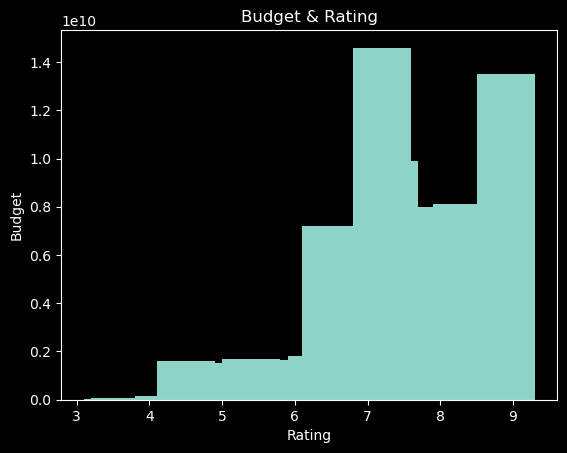

In [92]:
df_test = df[(df['Budget'].notna()) & (df['Rating'].notna()) & (df['Budget']!=0)]
df_test = df_test.drop_duplicates(subset = 'Title')[['Budget','Rating']]

plt.title('Budget & Rating')
plt.xlabel('Rating')
plt.ylabel('Budget')
plt.bar(df_test['Rating'],df_test['Budget'])
plt.show()

*Our hypothesis is confirmed. We can observe that as the rating increases, so does the budget. However, for films with a rating of 8, we notice that the budget is not as high. This is likely due to the uneven distribution:*

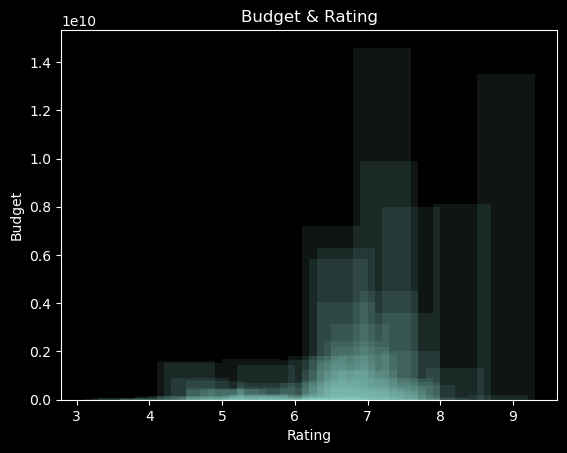

In [93]:
plt.title('Budget & Rating')
plt.xlabel('Rating')
plt.ylabel('Budget')
plt.bar(df_test['Rating'],df_test['Budget'], alpha=0.1)
plt.show()

*The majority of films fall between the ratings of 6 and 8.*

#### **Budget & Year of release.**

*This might not indicate a correlation because I only collected data for films released in Russia in 2023. I intended to examine the relationship between international release and budget.*

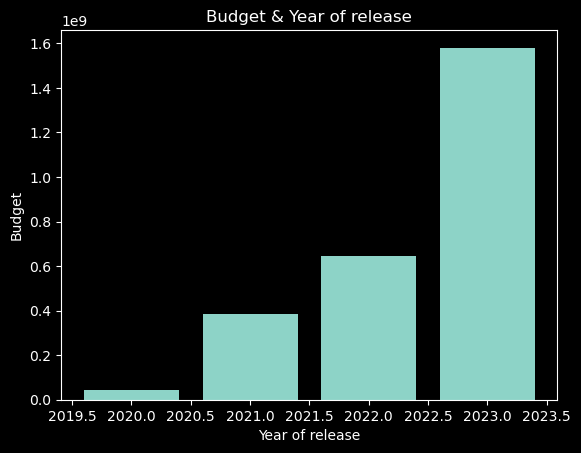

In [94]:
df_test = df[(df['Budget'].notna()) & (df['Year of release'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')[['Budget','Year of release']]
df_test = df_test.groupby(['Year of release'])['Budget'].mean().reset_index()


plt.title('Budget & Year of release')
plt.xlabel('Year of release')
plt.ylabel('Budget')
plt.bar(df_test['Year of release'],df_test['Budget'])
plt.show()

*The correlation is evident :D*

#### **Budget & Genre.**

*Let's explore the interesting relationship between budget and genres.*

**Hypothesis:**

*The top genres by budget are fantasy and action.*

In [95]:
df_test = df[(df['Budget'].notna()) & (df['Genre'].notna())]
df_test = df_test[['Budget','Genre']]
df_test = df_test.groupby(['Genre'])['Budget'].mean().reset_index().sort_values(by = 'Budget', ascending=False)
df_test.head(5)

,Genre,Budget
2,боевик,4.914883e+09
9,исторический,2.907099e+09
1,биография,2.817966e+09
15,приключения,2.721731e+09
14,музыка,2.430000e+09


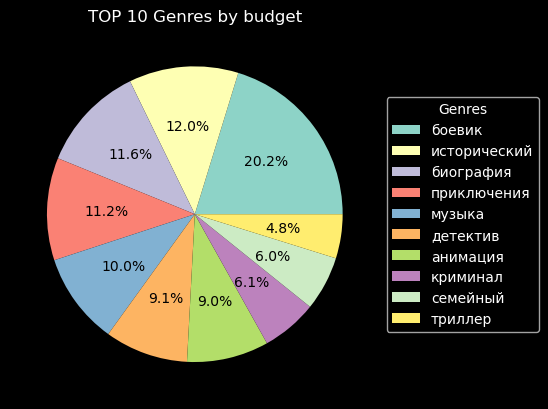

In [96]:
data = df_test['Budget'][:10]
genres = df_test['Genre'][:10]

plt.pie(data, autopct=lambda pct: f"{pct:.1f}%", textprops=dict(color="k"))

plt.legend(genres,
          title="Genres",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("TOP 10 Genres by budget")

plt.show()

*We almost guessed right. Action is in the first place, but fantasy is not even in the top 10. The leading positions are held by action, historical, and biography films.*

### **Movie Distributor.**

#### **Movie Distributors distribution.**

*I was interested in constructing this distribution to examine the market share of different distributors and understand how they contribute to the overall market.*

*Earlier, we created a similar distribution, but based on the budget. This led me to formulate a hypothesis.*

**Hypothesis:**

*The top companies in terms of budget released the highest number of films.*

Text(0.5, 1.0, 'TOP 10 Movie Distributors by max number of films')

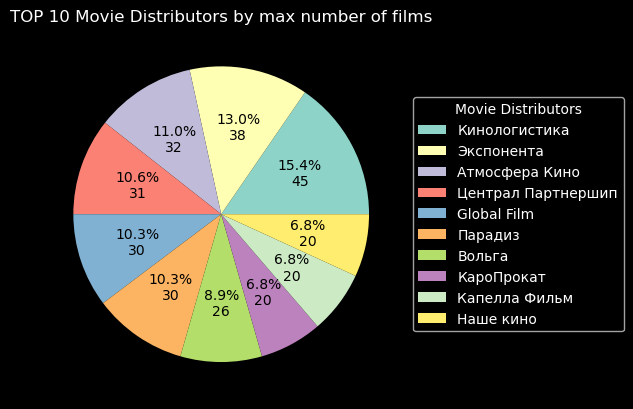

In [97]:
df_test = df[(df['Movie distributor'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')
df_test = df_test.groupby(['Movie distributor'])['Title'].count().reset_index().sort_values(by = 'Title', ascending=False)
df_test = df_test.rename(columns = {'Title':'Number of films'})

data = df_test['Number of films'][:10]
distributors = df_test['Movie distributor'][:10]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n{absolute:d}"

plt.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="k"))

plt.legend(distributors,
          title="Movie Distributors",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('TOP 10 Movie Distributors by max number of films')

*On the diagram depicting the distribution of distributors by budget, we will observe that the leading positions are held by Волга, Каропрокат, Парадиз, Экспонента, Global Film. On the above diagram, we can see that Экспонента is in the second position, and Global Film is in the fifth position. This partially contradicts our hypothesis. Budget does not correlate with the number of films, as there could be one film with a large budget and 100 films with smaller budgets, yet their total sums would be equal.*

#### **Movie Distributor & Rating.**

*Also, it would be interesting to examine the relationship between the distributor and the rating.*

**Hypothesis:**

*The top distributors by budget also have top ratings.*

In [98]:
df_test = df[(df['Movie distributor'].notna()) & (df['Rating'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')[['Movie distributor','Rating']]
df_test = df_test.groupby('Movie distributor')['Rating'].mean().reset_index().sort_values(by = 'Rating', ascending= False)
df_test.head(5)

,Movie distributor,Rating
7,Indian Films,7.650000
35,Центр документального кино,7.000000
0,A-One Films,6.766667
4,BASE Development,6.750000
28,ПРОвзгляд,6.611111


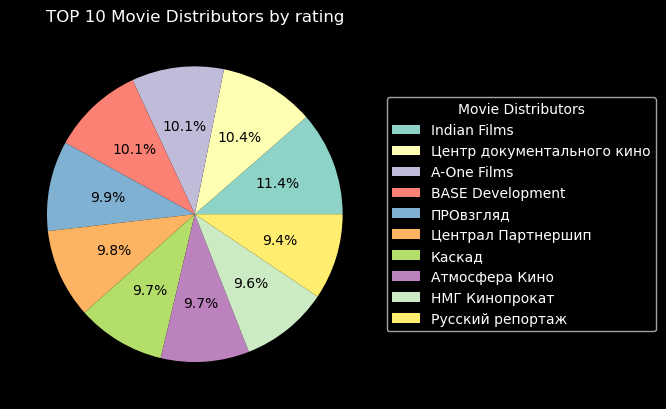

In [99]:
data = df_test['Rating'][:10]
distributors = df_test['Movie distributor'][:10]

plt.pie(data, autopct=lambda pct: f"{pct:.1f}%", textprops=dict(color="k"))

plt.legend(distributors,
          title="Movie Distributors",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("TOP 10 Movie Distributors by rating")

plt.show()

*It's very interesting that none of the top distributors by budget are included in this diagram. Our hypothesis is not confirmed.*

#### **Movie Distributor & Year of release.**

*This table was created out of curiosity, despite the fact that we parsed the data for the year 2023. :D*

C:\Users\My End_1ess C\AppData\Local\Temp\ipykernel_2196\312790285.py:4: FutureWarning: The provided callable <function sum at 0x000002004B0CA3E0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_test = pd.pivot_table(df_test, index = 'Movie distributor', columns='Year of release', values = 'num', aggfunc=np.sum)


<Axes: xlabel='Year of release', ylabel='Movie distributor'>

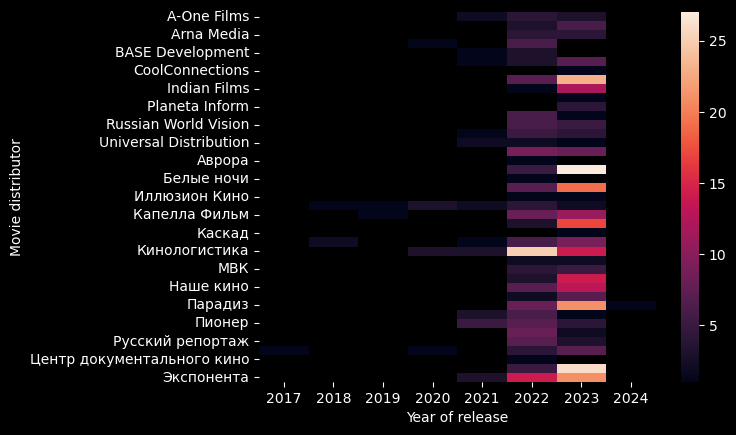

In [100]:
df_test = df[(df['Movie distributor'].notna()) & (df['Year of release'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')[['Movie distributor','Year of release']]
df_test['num'] = 1
df_test = pd.pivot_table(df_test, index = 'Movie distributor', columns='Year of release', values = 'num', aggfunc=np.sum)

sns.heatmap(df_test)

*Mainly releases in 2022 and 2023.*

#### **Movie Distributor & Genre.**

*Here, it will be useful to see which genres distributors prefer.*

**Hypothesis:**

*The most preferred genres are biography, action, and fantasy.*

C:\Users\My End_1ess C\AppData\Local\Temp\ipykernel_2196\2772696505.py:4: FutureWarning: The provided callable <function sum at 0x000002004B0CA3E0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_test = pd.pivot_table(df_test, index = 'Movie distributor', columns='Genre', values = 'num', aggfunc=np.sum)


<Axes: xlabel='Genre', ylabel='Movie distributor'>

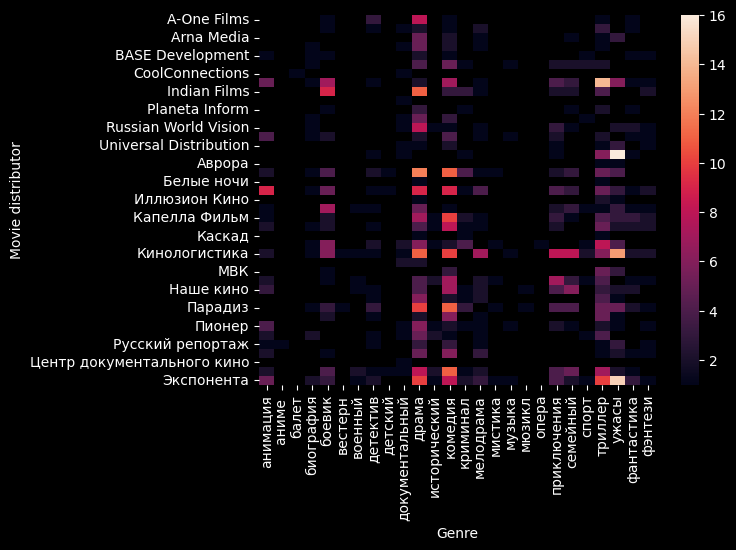

In [101]:
df_test = df[(df['Movie distributor'].notna()) & (df['Genre'].notna())]
df_test = df_test[['Movie distributor','Genre']]
df_test['num'] = 1
df_test = pd.pivot_table(df_test, index = 'Movie distributor', columns='Genre', values = 'num', aggfunc=np.sum)

sns.heatmap(df_test)

*We were wrong. The preferred genres for distributors are thriller, drama, and comedy.*

### **Rating.**

*Let's assume that the average rating is 7, then conduct a test to confirm or reject this hypothesis.*

In [102]:
df_test = list(df[df['Rating'].notna()].drop_duplicates(subset = 'Title')['Rating'])
stats.ttest_1samp(a=df_test, popmean = 7)

C:\Users\My End_1ess C\AppData\Local\Temp\ipykernel_2196\295724173.py:2: DeprecationWarning: Please use `ttest_1samp` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.ttest_1samp(a=df_test, popmean = 7)


TtestResult(statistic=-18.774366850567777, pvalue=3.198404504749002e-60, df=512)

Statistic = -18.77 and pvalue = 3.2

Since the p-value of our test (3.2) is greater than alpha = 0.05, we cannot reject the null hypothesis of the test. We lack sufficient evidence to claim that the average rating is not equal to 7.

#### **Rating distribution.**

*Let's also create a distribution to examine the overall perspective of ratings.*

(array([  2.,   1.,   4.,   6.,  18.,  18.,  30.,  47.,  68., 113.,  82.,
         82., 160., 102.,  98.,  66.,  36.,  13.,  15.,   7.]),
 array([2.   , 2.355, 2.71 , 3.065, 3.42 , 3.775, 4.13 , 4.485, 4.84 ,
        5.195, 5.55 , 5.905, 6.26 , 6.615, 6.97 , 7.325, 7.68 , 8.035,
        8.39 , 8.745, 9.1  ]),
 <BarContainer object of 20 artists>)

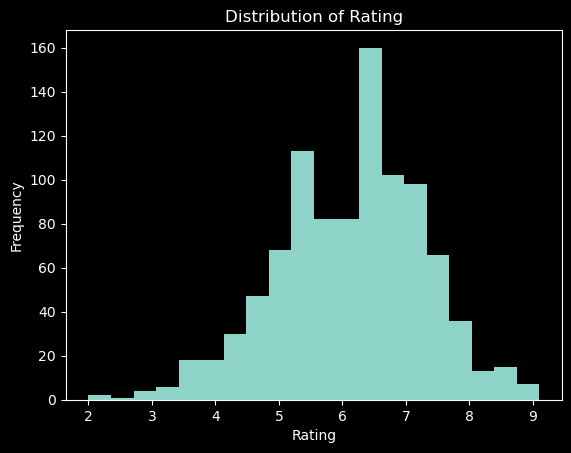

In [103]:
df_test = df[(df['Rating'].notna())]
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.hist(df_test['Rating'], bins = 20)

*We also can notice that movies typically receive ratings in the range of approximately 5.5 to 7.5. Utilizing a normal distribution can aid in pinpointing data errors and estimating the average movie rating, for instance.*

#### **Rating & Genre.**

*This correlation can be useful to determine which genre receives the highest ratings.*

**Hypothesis:**

*The genres with the highest ratings are biography and documentary.*

In [104]:
df_test = df[(df['Genre'].notna()) & (df['Rating'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')[['Genre','Rating']]
df_test = df_test.groupby('Genre')['Rating'].mean().reset_index().sort_values(by = 'Rating', ascending= False)
df_test.head(5)

,Genre,Rating
3,военный,7.600000
6,документальный,7.383333
10,криминал,6.641667
1,биография,6.641667
13,мюзикл,6.450000


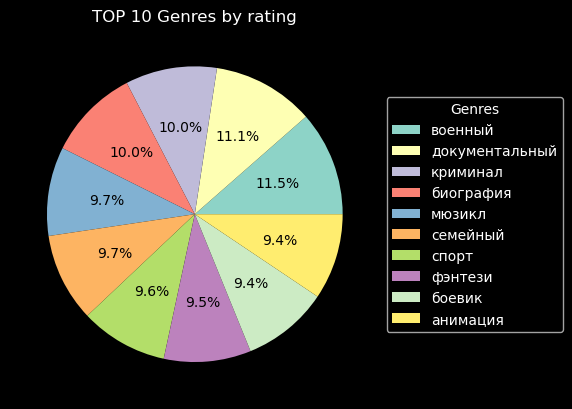

In [105]:
data = df_test['Rating'][:10]
genres = df_test['Genre'][:10]

plt.pie(data, autopct=lambda pct: f"{pct:.1f}%", textprops=dict(color="k"))

plt.legend(genres,
          title="Genres",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("TOP 10 Genres by rating")

plt.show()

*As we can see, documentary is in the second place of the top, and biography is in fourth place. We were right. Additionally, the leading genres in terms of ratings are military, crime, and musical. I actually didn't expect musical to be there at all. Very interesting!*

### **Analysis by month.**

*Preprocessing. Adding new column with monthes.*

In [106]:
months = {
     '01': 'январь',
     '02': 'февраль',
     '03': 'март',
     '04': 'апрель',
     '05': 'май',
     '06': 'июнь',
     '07': 'июль',
     '08': 'август',
     '09': 'сентябрь',
     '10': 'октябрь',
     '11': 'ноябрь',
     '12': 'декабрь',
}

def to_month(x):
     return months[str(x)[5:7]]


df['Month'] = df['Premiere in Russia'].apply(to_month)

#### **Months distribution.**

*Let's take a look at the distribution of films by months.*

**Hypothesis:**

*The highest number of films is concentrated during the summer period.*

(array([ 66.,  44.,  46.,  39.,  63.,  40.,  49.,  44.,  54., 106.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

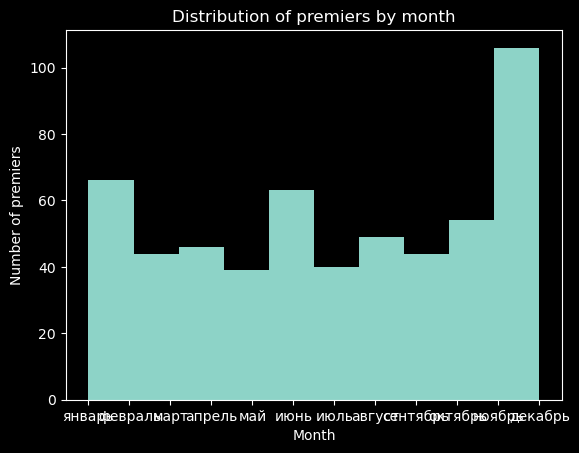

In [107]:
df_test = df[(df['Premiere in Russia'].notna())]
df_test = df_test.drop_duplicates(subset='Title')
plt.title('Distribution of premiers by month')
plt.ylabel('Number of premiers')
plt.xlabel('Month')
plt.hist(df_test['Month'])

Yes, the chart indicates that June is one of the busiest months in terms of film releases, but looking at other months, the peak actually falls during the winter period. Our hypothesis is refuted.

#### **Months & Mpaa.**

*Examining months and MPAA ratings can provide insights into the distribution of age ratings throughout the year.*

C:\Users\My End_1ess C\AppData\Local\Temp\ipykernel_2196\3972640060.py:4: FutureWarning: The provided callable <function sum at 0x000002004B0CA3E0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_test = pd.pivot_table(df_test, index = 'Month', columns='Mpaa', values = 'num', aggfunc=np.sum)


<Axes: xlabel='Mpaa', ylabel='Month'>

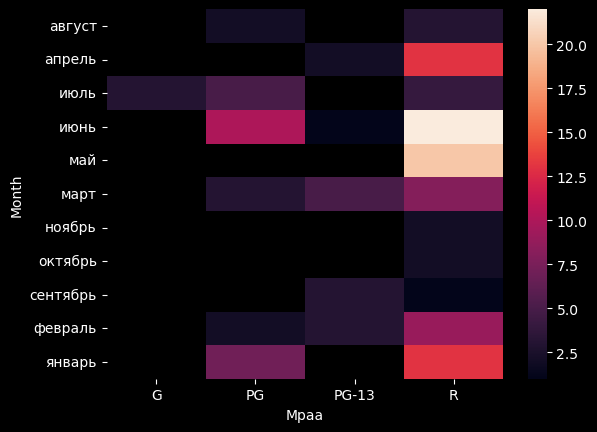

In [108]:
df_test = df[(df['Premiere in Russia'].notna()) & (df['Mpaa'].notna())]
df_test = df_test[['Month','Mpaa']]
df_test['num'] = 1
df_test = pd.pivot_table(df_test, index = 'Month', columns='Mpaa', values = 'num', aggfunc=np.sum)

sns.heatmap(df_test)

*Thanks to this table, we can observe each category throughout the year. The R group predominates, with the highest occurrences in May and June.*

#### **Months & Rating.**

*The correlation between months and ratings can reveal the distribution throughout the year. We can identify the months with the highest ratings.*

**Hypothesis:**

*The ratings for films are higher during the summer.*

In [109]:
df_test = df[(df['Premiere in Russia'].notna()) & (df['Rating'].notna())]
df_test = df_test[['Month','Rating']]
df_test = df_test.groupby(['Month'])['Rating'].mean().reset_index().sort_values(by = 'Rating', ascending=False)
df_test.head(5)

,Month,Rating
9,сентябрь,6.531579
2,декабрь,6.477586
3,июль,6.325316
4,июнь,6.296460
7,ноябрь,6.293548


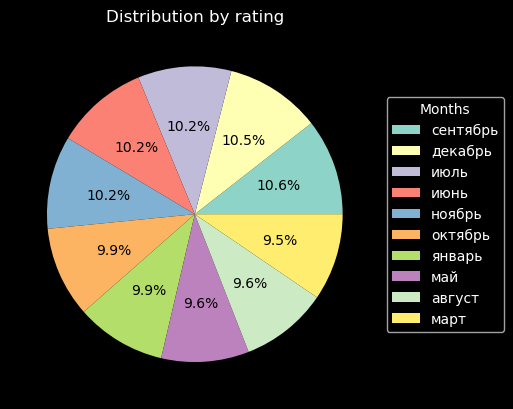

In [110]:
data = df_test['Rating'][:10]
months = df_test['Month'][:10]

plt.pie(data, autopct=lambda pct: f"{pct:.1f}%", textprops=dict(color="k"))

plt.legend(months,
          title="Months",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Distribution by rating")

plt.show()

*Despite September and December being in the lead, June and July are in the third and fourth positions, so we can say that our assumptions were correct.*

#### **Months & Genre.**

*The correlation between months and genres can help us see which genres predominated in each month.*

**Hypothesis:**

*Comedies dominate during the summer months.*

C:\Users\My End_1ess C\AppData\Local\Temp\ipykernel_2196\758878100.py:4: FutureWarning: The provided callable <function sum at 0x000002004B0CA3E0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_test = pd.pivot_table(df_test, index = 'Month', columns='Genre', values = 'num', aggfunc=np.sum)


<Axes: xlabel='Genre', ylabel='Month'>

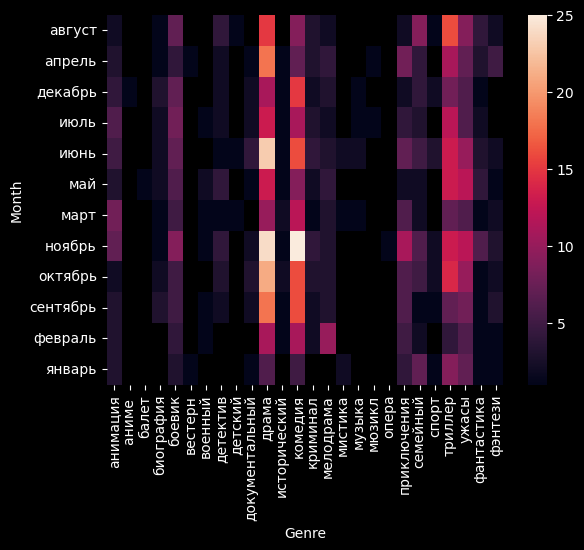

In [111]:
df_test = df[(df['Premiere in Russia'].notna()) & (df['Genre'].notna())]
df_test = df_test[['Month','Genre']]
df_test['num'] = 1
df_test = pd.pivot_table(df_test, index = 'Month', columns='Genre', values = 'num', aggfunc=np.sum)

sns.heatmap(df_test)

*We see a trend with the quantity of comedies in June; however, the main months are September, October, and November, which are in the spring. The hypothesis is not confirmed.*

### **Producer.**

#### **Producer Distribution.**

*It would be interesting to find out if there are producers who have directed more than one film.*

In [112]:
df_test = df[(df['Producer'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')
df_test = df_test.groupby(['Producer'])['Title'].count().reset_index().sort_values(by = 'Title', ascending=False)
df_test = df_test.rename(columns = {'Title':'Number of films'})
df_test.head(5)

,Producer,Number of films
0,Андрей Фурманчук,1
369,Нимрод Антал,1
363,Николай Рыбников,1
364,Николь Паон,1
365,Николя Лемэй,1


*No producers have more than one film.*

#### **Producer & Budget.**

*Out of curiosity, let's take a look at producers distributed by budget.*

In [113]:
df_test = df[(df['Producer'].notna()) & (df['Budget'].notna()) & (df['Budget'] != 0)]
df_test = df_test.drop_duplicates(subset = 'Title')[['Producer', 'Budget']].sort_values(by = 'Budget', ascending = False)
df_test.head(5)

,Producer,Budget
209,Франт Гво,1.459260e+10
350,Жоаким Дос Сантос,1.350000e+10
997,Майкл Манн,9.900000e+09
163,Чад Стахелски,8.100000e+09
589,Джереми Заг,8.000000e+09


Text(0.5, 1.0, 'TOP 10 Producer by budget')

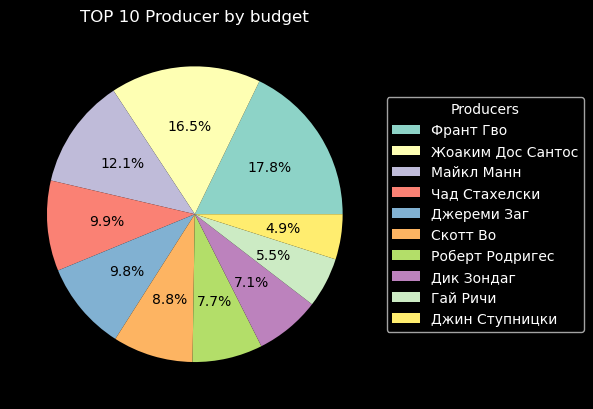

In [114]:
data = df_test['Budget'][:10]
producers = df_test['Producer'][:10]

plt.pie(data,autopct=lambda pct: f"{pct:.1f}%", textprops=dict(color="k"))
plt.legend(producers,
           title = 'Producers',
            loc = 'center left',
            bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('TOP 10 Producer by budget')


*We have obtained our pie chart where we can see the top producers by budget.*

#### **Producer & Rating.**

*Let's also create one for ratings, just out of curiosity.*

In [115]:
df_test = df[(df['Producer'].notna()) & (df['Rating'].notna())]
df_test = df_test.drop_duplicates(subset = 'Title')[['Producer', 'Rating']].sort_values(by = 'Rating', ascending = False)
df_test.head(5)

,Producer,Rating
522,Пак Ён-гюн,9.1
350,Жоаким Дос Сантос,8.9
684,Билал Лашари,8.8
791,Локеш Канагарадж,8.6
432,Рон Чэпмен,8.4


Text(0.5, 1.0, 'TOP 10 Producer by rating')

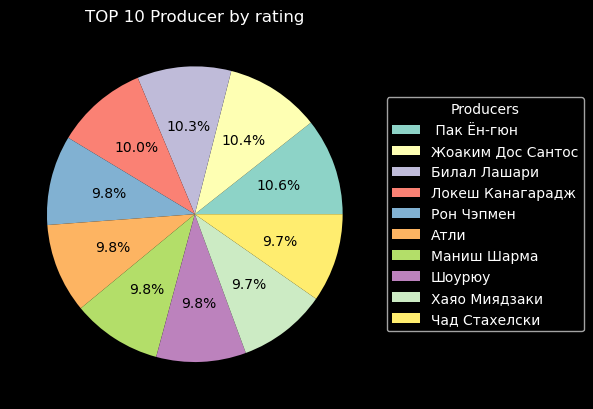

In [116]:

data = df_test['Rating'][:10]
producers = df_test['Producer'][:10]

plt.pie(data,autopct=lambda pct: f"{pct:.1f}%", textprops=dict(color="k"))
plt.legend(producers,
           title = 'Producers',
            loc = 'center left',
            bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('TOP 10 Producer by rating')

*Our pie chart illustrates the distribution of producers by rating, and the difference is minimal.*

### **Brief Summaries and Observations**

*1. The higher the age category, the longer the average film duration.*

*2. The longer the duration, the higher the budget.*

*3. The higher the rating, the longer the duration.*

*4. Distributors prefer films with higher age categories.*

*5. On average, ratings are higher for lower age categories.*

*6. The higher the budget, the higher the average rating.*

*7. It's fascinating that the fantasy genre doesn't even make it to the top 10 in budget distribution.*

*8. It was also interesting to note that top-budget distributors didn't make it to the top in terms of ratings.*

*9. Additionally, it's intriguing that distributors predominantly favor genres such as drama, comedy, thriller, and slightly less so, action.*

*10. Genres like war, documentary, crime, and biography have the highest ratings.*

*11. The highest number of released films is concentrated in the winter period, with a peak in comedy and drama genres in November.*

### **Have I found points of growth?**

**Optimizing Genre Budget Allocation:**

*Attention to budget distribution across various genres can serve as a foundation for optimizing budget planning. Focusing on less competitive genres with high rating potential may lead to increased expenditure efficiency and overall profit growth.*

**Seasonal Promotions and Advertising Campaigns:**

*Considering the concentration of film releases during the winter period, a strategy could involve conducting seasonal promotions and advertising campaigns leading up to this season. This may stimulate viewer interest, increase viewership, and consequently boost box office revenues.*